# SAMap preprocess
With leiden-based neighborhoods

In [2]:
from samap.mapping import SAMAP
from samalg import SAM
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings(action='ignore')
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

## Set parameters

In [3]:
# species A
sp_stage_A='Dr60Epiboly'
abbr_A='dr' # must be equal to filename under blast map folder
h5ad_A='zf_farrell7_ZF60.h5ad'

# species B
sp_stage_B='Nv24hr'
abbr_B='nv' # must be equal to filename under blast map folder
h5ad_B='Gastrula24hrFINAL.h5ad'

# blast maps and id maps
g_map_folder='./maps_prot/'

## Read gene name mapping

Parse mapping of transcript ids vs gene names used in the anndata object

In [4]:
with open(g_map_folder+'/'+abbr_A+'_idmap.csv') as f:
    idmap_A=[tuple(line) for line in csv.reader(f)][2:]

with open(g_map_folder+'/'+abbr_B+'_idmap.csv') as f:
    idmap_B=[tuple(line) for line in csv.reader(f)][2:]

print(abbr_A+" first five gene ids:")
print(idmap_A[:5])
print(abbr_B+" first five gene ids:")
print(idmap_B[:5])

dr first five gene ids:
[('XP_017213390.1', 'ttnb'), ('XP_685984.6', 'si:ch211-250g4.3'), ('XP_017209112.1', 'si:dkey-9l20.3'), ('XP_009294587.1', 'LOC100330916'), ('XP_017208113.1', 'adgrf6')]
nv first five gene ids:
[('NV2t025877001.1', 'XPO4-like-1'), ('NV2t025878001.1', 'NV2.25878'), ('NV2t025879001.1', 'XPO4-like-3'), ('NV2t025880001.1', 'RISC-like-1'), ('NV2t025881001.1', 'NV2.25881')]


# Running SAMap

## Loading in raw data

Instantiate the SAMAP object.

In [5]:
sm = SAMAP(
        {abbr_A : h5ad_A , abbr_B : h5ad_B},
        f_maps = g_map_folder,
        names = {abbr_A : idmap_A , abbr_B : idmap_B},
        save_processed=False
    )

Processing data dr from:
zf_farrell7_ZF60.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8358306488545146
Iteration: 2, Convergence: 0.013973423092075483
Computing the UMAP embedding...
Elapsed time: 28.046525478363037 seconds
Not updating the manifold...
Processing data nv from:
Gastrula24hrFINAL.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8226685731087713
Iteration: 2, Convergence: 0.021857362163389453
Computing the UMAP embedding...
Elapsed time: 26.21676230430603 seconds
Not updating the manifold...
12062 `dr` gene symbols match between the datasets and the BLAST graph.
13854 `nv` gene symbols match between the datasets and the BLAST graph.


Show unintegrated umaps.

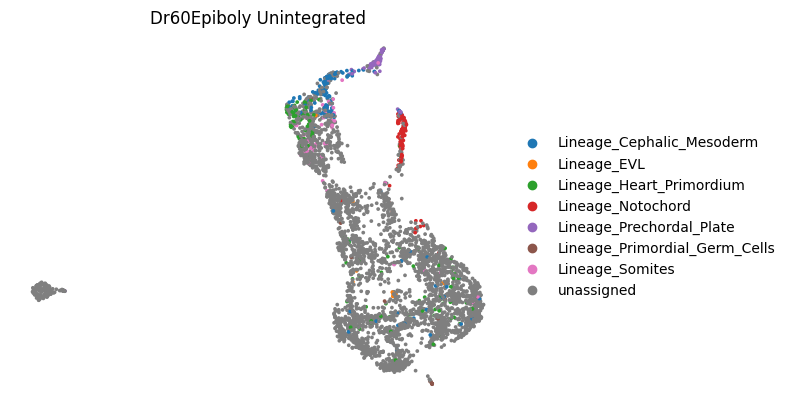

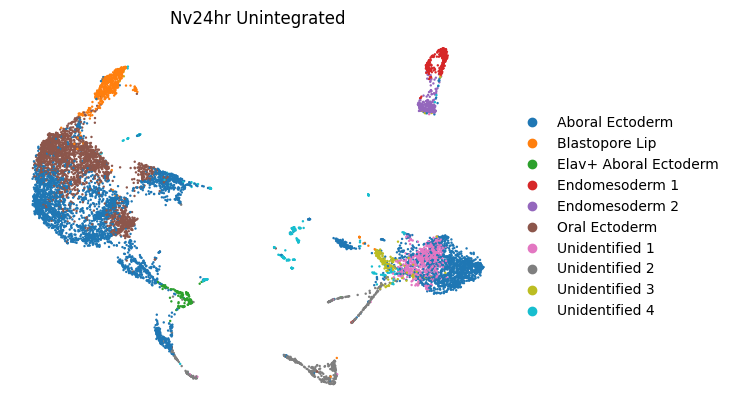

In [6]:
sc.pl.embedding(sm.sams[abbr_A].adata,
                    basis='X_umap',
                    color='celltype',
                title=(sp_stage_A+' Unintegrated'),
                    frameon=False)

sc.pl.embedding(sm.sams[abbr_B].adata,
                    basis='X_umap',
                title=(sp_stage_B+' Unintegrated'),
                    color='cell_type',
                    frameon=False)

## Run SAMap

In [7]:
sm.run(ncpus=4)

Prepping datasets for translation.
Translating feature spaces pairwise.
Projecting data into joint latent space. 5.565286636352539
Correcting data with means. 8.429872989654541
Expanding neighbourhoods of species dr...
Expanding neighbourhoods of species nv...
Indegree coarsening
0/1 (0, 14101)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 1 complete.
Alignment scores:
          dr        nv
dr  0.000000  0.454327
nv  0.354538  0.000000
Calculating gene-gene correlations in the homology graph...
Prepping datasets for translation.
Translating feature spaces pairwise.
Projecting data into joint latent space. 4.935377836227417
Correcting data with means. 7.318600654602051
Expanding neighbourhoods of species dr...
Expanding neighbourhoods of species nv...
Indegree coarsening
0/1 (0, 14101)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 2 complete.
Alignment scores:
          dr        nv
dr  0.000000  0.

Save samap object.

In [8]:
save_object(sm,'sam_processed.pkl')

## Visualizing the combined projection

<Axes: title={'center': 'SAMap UMAP Dr60Epiboly (red) vs Nv24hr (blue)'}>

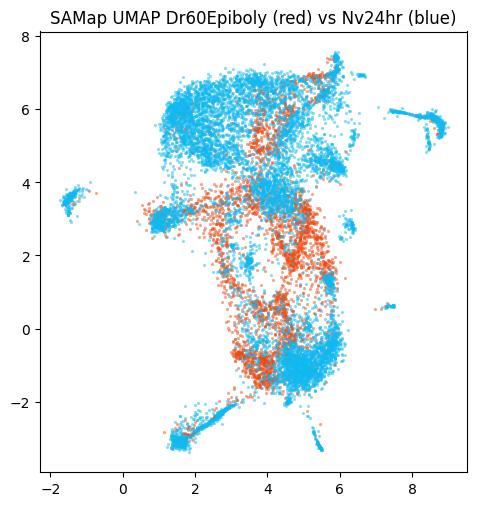

In [9]:
fig, ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(5)
fig.tight_layout()
ax.set_title('SAMap UMAP '+sp_stage_A+' (red) vs '+sp_stage_B+' (blue)')
sm.scatter(COLORS={abbr_B:'#10b9f1',abbr_A:'#f14810'},axes=ax,ss={abbr_A:5,abbr_B:5},alpha=0.5)

# Save parameters

In [10]:
params_d={
'sp_stage_A' : sp_stage_A,
'abbr_A' : abbr_A,
'h5ad_A' : h5ad_A,
'sp_stage_B' : sp_stage_B,
'abbr_B' : abbr_B,
'h5ad_B' : h5ad_B,
'g_map_folder' : g_map_folder}

pd.DataFrame.from_dict(data=params_d, orient='index').to_csv('samap_parameters.csv', header=False)